# Pricing and Promotion Analysis

# Prerequisites

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## Tables

In [2]:
skus = pd.read_csv('../../JD_sku_data.csv')
users = pd.read_csv('../../JD_user_data.csv')
clicks = pd.read_csv('../../JD_click_data.csv')
orders = pd.read_csv('../../JD_order_data.csv')
delivery = pd.read_csv('../../JD_delivery_data.csv')
inventory = pd.read_csv('../../JD_inventory_data.csv')
network = pd.read_csv('../../JD_network_data.csv')

## Data Preparation

In [3]:
clean_orders = pd.DataFrame(orders)
clean_orders = clean_orders[clean_orders['gift_item'] == 0]
clean_orders = clean_orders[clean_orders['type'] == 1]

clean_orders["total_discount"] = (clean_orders["original_unit_price"]-clean_orders["final_unit_price"])
clean_orders["perc_direct_disc"] = (clean_orders["direct_discount_per_unit"]/clean_orders["original_unit_price"])*100
clean_orders["perc_quantity_disc"] = (clean_orders["quantity_discount_per_unit"]/clean_orders["original_unit_price"])*100
clean_orders["perc_bundle_disc"] = (clean_orders["bundle_discount_per_unit"]/clean_orders["original_unit_price"])*100
clean_orders["perc_total_discount"] = (1-(clean_orders["final_unit_price"]/clean_orders["original_unit_price"]))*100

# next stage of preparation
condition1 ={'order_ID': lambda x: (x).count() ,'perc_direct_disc':  lambda x: (x).mean(),'perc_quantity_disc': [lambda x: (x).mean()],'perc_bundle_disc': [lambda x: (x).mean()], 'final_unit_price': [lambda x: (x).sum()]}
result = clean_orders.groupby('order_date').agg(condition1)
result = pd.DataFrame(result)
result.columns = result.columns.droplevel(1)
result = result.reset_index().rename(columns={result.columns[0]: 'total_purchases', result.columns[1]: 'direct_discount', result.columns[2]: 'quantity_discount', result.columns[3]: 'bundle_discount', result.columns[4]: 'total_revenue'})

# Impact of Discounts 

### Prep

                              percentage_direct_discount  \
percentage_direct_discount                      1.000000   
percentage_quantity_discount                    0.225387   
percentage_bundle_discount                      0.375539   

                              percentage_quantity_discount  \
percentage_direct_discount                        0.225387   
percentage_quantity_discount                      1.000000   
percentage_bundle_discount                        0.247206   

                              percentage_bundle_discount  
percentage_direct_discount                      0.375539  
percentage_quantity_discount                    0.247206  
percentage_bundle_discount                      1.000000  


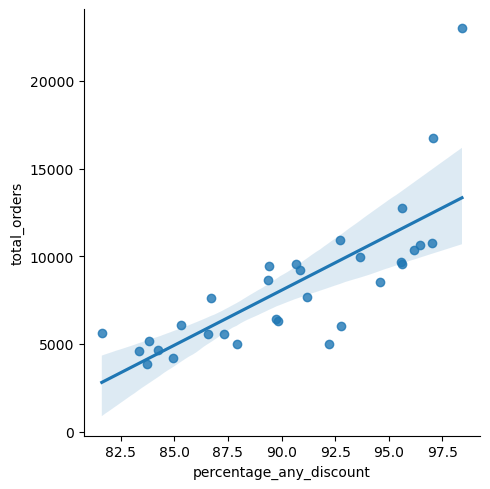

In [4]:
clean_orders1 = clean_orders
clean_orders1['direct_discount_per_unit'] = clean_orders['direct_discount_per_unit'].apply(lambda x: 1 if x > 0 else x)
clean_orders1['quantity_discount_per_unit'] = clean_orders['quantity_discount_per_unit'].apply(lambda x: 1 if x > 0 else x)
clean_orders1['bundle_discount_per_unit'] = clean_orders['bundle_discount_per_unit'].apply(lambda x: 1 if x > 0 else x)
clean_orders1['any_discount_per_unit'] = clean_orders['total_discount'].apply(lambda x: 1 if x > 0 else x)

condition2 ={'order_ID': lambda x: (x).count() ,'direct_discount_per_unit':  lambda x: (x).sum(),'quantity_discount_per_unit': lambda x: (x).sum(),'bundle_discount_per_unit': lambda x: (x).sum(),'any_discount_per_unit': lambda x: (x).sum(), 'final_unit_price': [lambda x: (x).sum()]}
clean_orders1 = clean_orders1.groupby('order_date').agg(condition2).reset_index()
clean_orders1.columns = ['order_date','total_orders','direct_discount','quantity_discount',
                         'bundle_discount','any_discount','total_revenue']

clean_orders1["percentage_direct_discount"] = (clean_orders1["direct_discount"]/clean_orders1["total_orders"])*100
clean_orders1["percentage_quantity_discount"] = (clean_orders1["quantity_discount"]/clean_orders1["total_orders"])*100
clean_orders1["percentage_bundle_discount"] = (clean_orders1["bundle_discount"]/clean_orders1["total_orders"])*100
clean_orders1["percentage_any_discount"] = (clean_orders1["any_discount"]/clean_orders1["total_orders"])*100

clean_orders1 = clean_orders1.drop(['direct_discount','quantity_discount','bundle_discount'],axis=1)

# Create correlation matrix
corr_matrix = clean_orders1[['percentage_direct_discount','percentage_quantity_discount',
                             'percentage_bundle_discount']].corr()

print(corr_matrix)
sns.lmplot(x="percentage_any_discount", y="total_orders", data=clean_orders1)
plt.show()

## Any Discount

### Orders any discount

In [5]:
# define the dependent and independent variables
X = clean_orders1[['percentage_any_discount',]]
y = clean_orders1['total_orders']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create an instance of the linear regression model
model = LinearRegression()

# fit the model to the training data
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# calculate the R-squared value
r_squared = r2_score(y_test, y_pred)

# print the R-squared value
print("R-squared:", r_squared)

print(pd.DataFrame(model.coef_).transpose(), model.intercept_)

# calculate the F-statistic
n = X.shape[0] # sample size
p = X.shape[1] # number of predictors
F = (r_squared / (1 - r_squared)) * ((n - p - 1) / p)

# print the F-statistic
print("F-statistic:", F)

# calculate the residuals
residuals = y_test - y_pred

# calculate the degrees of freedom
n = X_test.shape[0]
p = 1
df = n - p - 1

# calculate the standard error of the coefficient estimate
mse = np.mean(residuals**2)
se = np.sqrt(mse / ((n - 1) * np.var(X_test.values)))

# calculate the t-value
coef = model.coef_[0]
t_value = coef / se

# calculate the p-value
p_value = 1 - stats.t.cdf(t_value, df=df)

# print the t-value and p-value
print("t-value:", t_value)
print("p-value:", p_value)


R-squared: 0.630219911545191
            0
0  678.978491 -53066.110353555894
F-statistic: 49.42499070510148
t-value: 5.099430670208839
p-value: 0.0018859857217266018


### Revenue any discount

In [6]:
# define the dependent and independent variables
X = clean_orders1[['percentage_any_discount',]]
y = clean_orders1['total_revenue']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create an instance of the linear regression model
model = LinearRegression()

# fit the model to the training data
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# calculate the R-squared value
r_squared = r2_score(y_test, y_pred)

# print the R-squared value
print("R-squared:", r_squared)


print(pd.DataFrame(model.coef_).transpose(), model.intercept_)

# calculate the F-statistic
n = X.shape[0] # sample size
p = X.shape[1] # number of predictors
F = (r_squared / (1 - r_squared)) * ((n - p - 1) / p)

# print the F-statistic
print("F-statistic:", F)

# calculate the residuals
residuals = y_test - y_pred

# calculate the degrees of freedom
n = X_test.shape[0]
p = 1
df = n - p - 1

# calculate the standard error of the coefficient estimate
mse = np.mean(residuals**2)
se = np.sqrt(mse / ((n - 1) * np.var(X_test.values)))

# calculate the t-value
coef = model.coef_[0]
t_value = coef / se

# calculate the p-value
p_value = 1 - stats.t.cdf(t_value, df=df)

# print the t-value and p-value
print("t-value:", t_value)
print("p-value:", p_value)


R-squared: 0.6578803767512271
              0
0  46015.355427 -3404684.4799314654
F-statistic: 55.76567267500058
t-value: 4.067072364344816
p-value: 0.004830852159529608


## Each Discount

### Orders each discount

In [7]:
# define the dependent and independent variables
X = clean_orders1[['percentage_direct_discount', 'percentage_quantity_discount', 'percentage_bundle_discount']]
y = clean_orders1['total_orders']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create an instance of the StandardScaler object
scaler = StandardScaler()

# fit and transform the independent variables in the training set
X_train_scaled = scaler.fit_transform(X_train)

# transform the independent variables in the test set
X_test_scaled = scaler.transform(X_test)

# create an instance of the linear regression model
model = LinearRegression()

# fit the model to the training data
model.fit(X_train_scaled, y_train)

# fit a ridge regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# make predictions on the test data
y_pred = model.predict(X_test_scaled)

# calculate the R-squared value
r_squared = r2_score(y_test, y_pred)

# print the R-squared value
print("R-squared:", r_squared)

print(pd.DataFrame(ridge.coef_).transpose(), ridge.intercept_)

# calculate the F-statistic
n = X.shape[0] # sample size
p = X.shape[1] # number of predictors
F = (r_squared / (1 - r_squared)) * ((n - p - 1) / p)

# print the F-statistic
print("F-statistic:", F)

# calculate the residuals
residuals = y_test - y_pred

# calculate the degrees of freedom
n = X_test.shape[0]
p = 1
df = n - p - 1

# calculate the standard error of the coefficient estimate
mse = np.mean(residuals**2)
se = np.sqrt(mse / ((n - 1) * np.var(X_test_scaled)))

# calculate the t-value
coef = model.coef_
t_value = coef / se

# calculate the p-value
p_value = 1 - stats.t.cdf(t_value, df=df)

for i, col in enumerate(X_test.columns):
    print(f"{col}: t-value={t_value[i]}, p-value={p_value[i]}")

R-squared: 0.7560625874002316
             0            1          2
0  1227.246419  1875.137906  1360.1832 8682.25
F-statistic: 27.894709606379354
percentage_direct_discount: t-value=2.8445857720086543, p-value=0.018025957810821613
percentage_quantity_discount: t-value=4.434519352391424, p-value=0.0033997134866901035
percentage_bundle_discount: t-value=3.193580505216216, p-value=0.012083995137119441


### revenue each discount

In [8]:
# define the dependent and independent variables
X = clean_orders1[['percentage_direct_discount', 'percentage_quantity_discount', 'percentage_bundle_discount']]
y = clean_orders1['total_revenue']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# create an instance of the StandardScaler object
scaler = StandardScaler()

# fit and transform the independent variables in the training set
X_train_scaled = scaler.fit_transform(X_train)

# transform the independent variables in the test set
X_test_scaled = scaler.transform(X_test)

# create an instance of the linear regression model
model = LinearRegression()

# fit the model to the training data
model.fit(X_train_scaled, y_train)

# fit a ridge regression model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# make predictions on the test data
y_pred = model.predict(X_test_scaled)

# calculate the R-squared value
r_squared = r2_score(y_test, y_pred)

# print the R-squared value
print("R-squared:", r_squared)

print(pd.DataFrame(ridge.coef_).transpose(), ridge.intercept_)

# calculate the F-statistic
n = X.shape[0] # sample size
p = X.shape[1] # number of predictors
F = (r_squared / (1 - r_squared)) * ((n - p - 1) / p)

# print the F-statistic
print("F-statistic:", F)

# calculate the residuals
residuals = y_test - y_pred

# calculate the degrees of freedom
n = X_test.shape[0]
p = 1
df = n - p - 1

# calculate the standard error of the coefficient estimate
mse = np.mean(residuals**2)
se = np.sqrt(mse / ((n - 1) * np.var(X_test_scaled)))

# calculate the t-value
coef = model.coef_
t_value = coef / se

# calculate the p-value
p_value = 1 - stats.t.cdf(t_value, df=df)

for i, col in enumerate(X_test.columns):
    print(f"{col}: t-value={t_value[i]}, p-value={p_value[i]}")

R-squared: 0.6974138041700387
               0              1              2
0  135674.254691  112730.916034  106277.546053 761411.9795023551
F-statistic: 20.743590831412423
percentage_direct_discount: t-value=2.8669879572518964, p-value=0.01755905473660513
percentage_quantity_discount: t-value=2.362503971209034, p-value=0.03227506063666308
percentage_bundle_discount: t-value=2.227127427459047, p-value=0.03822020034719242


# Optimal Discount Rate

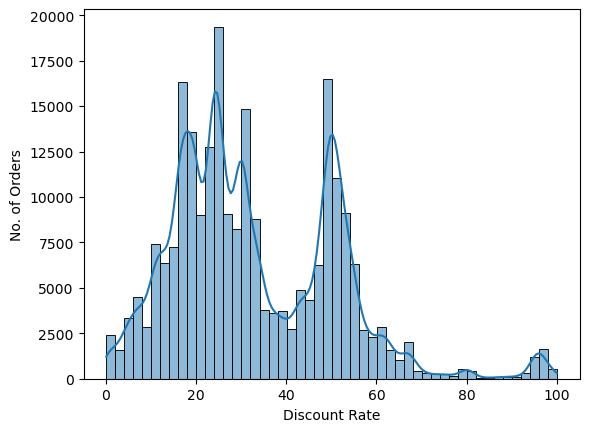

In [9]:
clean_ordersbarchart = clean_orders[clean_orders['perc_total_discount'] > 0 ]
barchart = sns.histplot(data=clean_ordersbarchart, x="perc_total_discount", binwidth=2, kde = True)
barchart.set(xlabel='Discount Rate',
       ylabel='No. of Orders')
plt.show()